In [1]:
%load_ext autoreload

In [77]:
%autoreload 2

from datetime import datetime, timezone, timedelta
import matplotlib.pyplot as plt
from omegaconf import OmegaConf
import os
import torch
import wandb

from RegularizingEmbeddings.lightning.train import make_trajectories, postprocess_data, generate_train_and_test_sets, SequenceModel, SequenceDataModule

In [2]:
project = 'sequence_model'
run_id = 'wpxhf6rl'

In [85]:
output_folder = f"../outputs"

In [118]:
def load_model(run_id, project, output_folder):

    # Get the output directory from wandbapi = wandb.Api()
    api = wandb.Api()
    run = api.run(f"{project}/{run_id}")
    config = run.config
    config = OmegaConf.create(config)

    # Initialize data module
    torch.random.manual_seed(config.data.flow.random_state)
    eq, sol, dt = make_trajectories(config)
    values = postprocess_data(config, sol)

    config.model.input_dim = values.shape[-1]

    # Create train and test sets
    train_dataset, val_dataset, test_dataset, trajs = generate_train_and_test_sets(values, **config.data.train_test_params)

    # Initialize model
    model = SequenceModel(config)

    # Get the run time
    run_time = datetime.strptime(run.created_at, '%Y-%m-%dT%H:%M:%SZ').replace(tzinfo=timezone.utc)
    run_time = run_time.astimezone(timezone(timedelta(hours=-5)))  # Convert to EST
    hydra_date = run_time.strftime('%Y-%m-%d')
    hydra_time = run_time.strftime('%H-%M-%S')

    run_time_folders = os.listdir(os.path.join(output_folder, hydra_date))

    # Find closest matching time folder
    def time_diff(t1, t2):
        # Convert time strings to datetime objects for comparison
        t1_dt = datetime.strptime(t1, '%H-%M-%S')
        t2_dt = datetime.strptime(t2, '%H-%M-%S')
        return abs((t1_dt - t2_dt).total_seconds())

    closest_time_folder = min(run_time_folders, key=lambda x: time_diff(x, hydra_time))

    # Load the model from the checkpoint with the largest epoch number
    checkpoint_files = os.listdir(os.path.join(output_folder, hydra_date, closest_time_folder, "checkpoints", "checkpoints"))
    checkpoint_files = [f for f in checkpoint_files if f.endswith(".ckpt")]
    checkpoint_epochs = [int(checkpoint_file.split('-')[1].split('=')[1]) for checkpoint_file in checkpoint_files]
    checkpoint_file = checkpoint_files[checkpoint_epochs.index(max(checkpoint_epochs))]
    checkpoint = torch.load(os.path.join(output_folder, hydra_date, closest_time_folder, "checkpoints", "checkpoints", checkpoint_file))
    model.load_state_dict(checkpoint['state_dict'])
    return config, model, train_dataset, val_dataset, test_dataset, trajs, values


In [119]:
config, model, train_dataset, val_dataset, test_dataset, trajs, values =load_model(run_id, project, output_folder)

Sequence Indices: 100%|██████████| 1175/1175 [00:00<00:00, 361418.83it/s]

Train dataset shape: torch.Size([16450, 25, 1])
Validation dataset shape: torch.Size([4700, 25, 1])
Test dataset shape: torch.Size([2350, 25, 1])
Train trajectories dataset shape: torch.Size([14, 1200, 1])
Validation trajectories dataset shape: torch.Size([4, 1200, 1])
Test trajectories dataset shape: torch.Size([2, 1200, 1])



/tmp/ipykernel_2921793/3698570230.py:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(output_folder, hydra_date, closest_time_folder, 

In [123]:
values_torch = torch.FloatTensor(values)

In [134]:
with torch.no_grad():
    out, hiddens = model.model(values_torch)

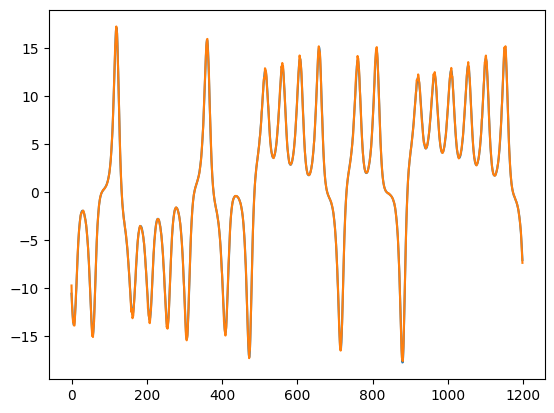

In [130]:
plt.plot(values[0, 1:, 0])
plt.plot(out[0, :-1, 0])
plt.show()


In [ ]:
hiddens = torch.dstack([hiddens.real, hiddens.imag])

In [137]:
class TorchPCA:
    def __init__(self, n_components=2):
        self.n_components = n_components
        self.components_ = None
        self.explained_variance_ = None
        self.explained_variance_ratio_ = None
        self.singular_values_ = None
        self.mean_ = None
        
    def fit(self, X):
        # X should be a torch tensor of shape (n_samples, n_features)
        self.mean_ = torch.mean(X, dim=0)
        X_centered = X - self.mean_

        # Compute covariance matrix
        n_samples = X.shape[0]
        cov_matrix = torch.matmul(X_centered.T, X_centered) / (n_samples - 1)

        # Compute eigenvalues and eigenvectors
        eigenvalues, eigenvectors = torch.linalg.eigh(cov_matrix)
        
        # Sort eigenvalues and eigenvectors in descending order
        indices = torch.argsort(eigenvalues, descending=True)
        eigenvalues = eigenvalues[indices]
        eigenvectors = eigenvectors[:, indices]

        # Store components and explained variance
        self.components_ = eigenvectors[:, :self.n_components].T
        self.explained_variance_ = eigenvalues[:self.n_components]
        total_var = torch.sum(eigenvalues)
        self.explained_variance_ratio_ = eigenvalues[:self.n_components] / total_var
        self.singular_values_ = torch.sqrt(eigenvalues[:self.n_components] * (n_samples - 1))
        
        return self
        
    def transform(self, X):
        X_centered = X - self.mean_
        X_transformed = torch.matmul(X_centered, self.components_.T)
        return X_transformed
        
    def fit_transform(self, X):
        return self.fit(X).transform(X)
        
    def inverse_transform(self, X):
        return torch.matmul(X, self.components_) + self.mean_


In [138]:
pca = TorchPCA(n_components=10)
pca.fit(hiddens.reshape(-1, hiddens.shape[-1]))


In [139]:
hiddens_pca = pca.fit_transform(hiddens.reshape(-1, hiddens.shape[-1])).reshape(hiddens.shape[0], hiddens.shape[1], -1)

In [141]:
hiddens_pca.shape

torch.Size([20, 1200, 10])

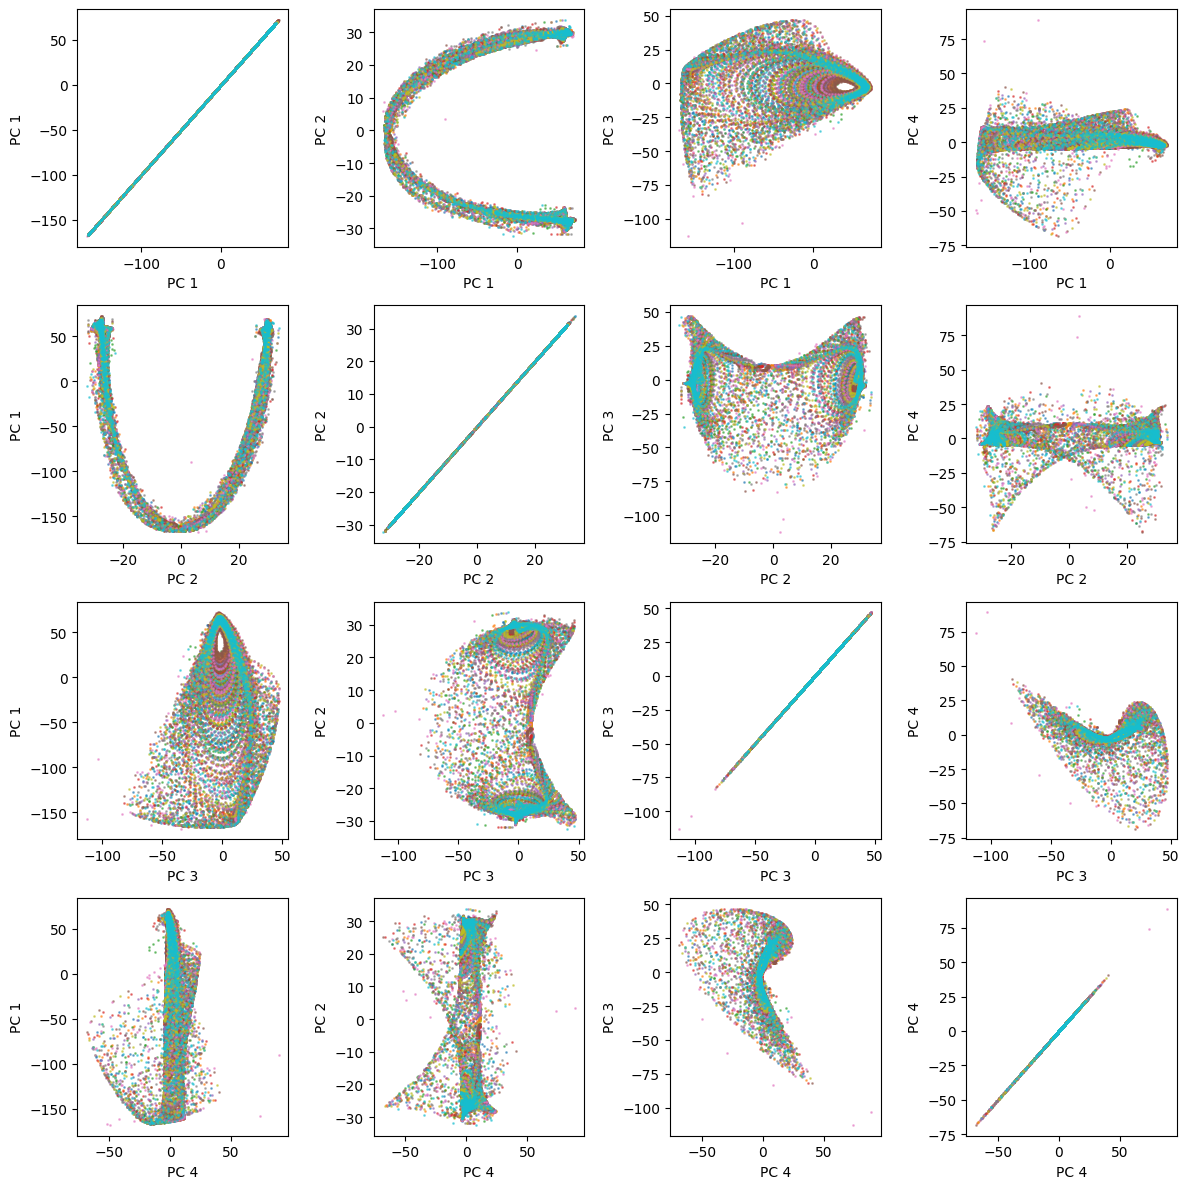

In [145]:
fig, axs = plt.subplots(4, 4, figsize=(12, 12))
for i in range(4):
    for j in range(4):
        for seq in range(hiddens_pca.shape[0]):
            axs[i,j].scatter(hiddens_pca[seq, :, i], hiddens_pca[seq, :, j], alpha=0.5, s=1)
        axs[i,j].set_xlabel(f'PC {i+1}')
        axs[i,j].set_ylabel(f'PC {j+1}')
plt.tight_layout()
plt.show()
